In [117]:
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [118]:
import pandas as pd
tx_data = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')
tx_data.head(10)
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We use six months of behavioral data to predict customers’ first purchase date in the next three months.

In [119]:
from datetime import datetime, timedelta,date

#create 3m and 6m dataframes
tx_6m = tx_uk[(tx_uk.InvoiceDate >= pd.to_datetime(date(2011,6,1))) & (tx_uk.InvoiceDate < pd.to_datetime(date(2011,12,1)))].reset_index(drop=True)
tx_next = tx_uk[(tx_uk.InvoiceDate < pd.to_datetime(date(2011,6,1))) & (tx_uk.InvoiceDate >= pd.to_datetime(date(2011,3,1)))].reset_index(drop=True)

#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

By using the data in tx_next, we need the calculate our label (days between last purchase before cut off date and first purchase after that)

In [120]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

#fill NA values with 999
tx_user = tx_user.fillna(999)

#print tx_user
tx_user.head()


,CustomerID,NextPurchaseDay
0,15643.0,-104.0
1,14842.0,999.0
2,15124.0,999.0
3,16422.0,-265.0
4,15240.0,-197.0


### RFM Cluster

In [121]:
import plotly.offline as pyoff
import plotly.graph_objs as go

#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

tx_user.head()




,CustomerID,NextPurchaseDay,Recency
0,15643.0,-104.0,170
1,14842.0,999.0,26
2,15124.0,999.0,13
3,16422.0,-265.0,8
4,15240.0,-197.0,35


In [122]:
# plot recency
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]
plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [123]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [124]:
#clustering for Recency
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [125]:
#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,331.0,155.105740,16.000502,127.0,142.0,155.0,168.0,182.0
1,396.0,97.328283,15.471601,75.0,83.0,97.0,110.0,126.0
2,825.0,50.820606,11.606903,33.0,41.0,50.0,61.0,73.0
3,1615.0,12.852632,9.089904,0.0,6.0,12.0,20.0,31.0


In [126]:
#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,15643.0,-104.0,170,0,13
1,14377.0,-71.0,182,0,7
2,16424.0,999.0,182,0,5
3,13475.0,-71.0,182,0,7
4,17472.0,999.0,182,0,60


In [127]:
#plot frequency
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [128]:
#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])


In [129]:
#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2577.0,32.412883,24.608414,1.0,12.0,26.0,48.0,97.0
1,534.0,163.189139,59.168692,98.0,116.0,144.0,194.0,354.0
2,53.0,549.358491,209.625958,363.0,418.0,470.0,614.0,1275.0
3,3.0,4315.666667,1240.828890,2958.0,3778.0,4598.0,4994.5,5391.0


In [130]:
#calculate monetary value, create a dataframe with it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

#add Revenue column to tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,15643.0,-104.0,170,0,13,0,310.30
1,14377.0,-71.0,182,0,7,0,302.45
2,16424.0,999.0,182,0,5,0,133.56
3,13475.0,-71.0,182,0,7,0,153.30
4,17472.0,999.0,182,0,60,0,259.27


In [131]:
#plot Revenue
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [132]:
#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


In [133]:
#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2968.0,704.020894,651.588202,-4287.63,242.0625,482.065,995.410,3072.00
1,178.0,5416.194494,2746.521896,3075.87,3562.7175,4357.385,6200.210,16756.31
2,19.0,29509.454211,9519.707328,18679.01,20723.8150,27528.660,34380.055,49285.37
3,2.0,155893.190000,34755.514519,131317.33,143605.2600,155893.190,168181.120,180469.05


In [134]:
#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,15643.0,-104.0,170,0,13,0,310.30,0,0,Low-Value
1,14377.0,-71.0,182,0,7,0,302.45,0,0,Low-Value
2,16424.0,999.0,182,0,5,0,133.56,0,0,Low-Value
3,13475.0,-71.0,182,0,7,0,153.30,0,0,Low-Value
4,17472.0,999.0,182,0,60,0,259.27,0,0,Low-Value


In [135]:
#plot revenue vs frequency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot revenue vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot frequency vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### Invoice dates

In [136]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]
#convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay
29506,12747.0,2011-06-28 10:06:00,2011-06-28
89217,12747.0,2011-08-22 10:38:00,2011-08-22
149449,12747.0,2011-10-04 08:26:00,2011-10-04
243849,12747.0,2011-11-17 17:13:00,2011-11-17
5124,12748.0,2011-06-06 11:46:00,2011-06-06


In [137]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
29506,12747.0,2011-06-28 10:06:00,2011-06-28,NaN,NaN,NaN
89217,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,NaN,NaN
149449,12747.0,2011-10-04 08:26:00,2011-10-04,2011-08-22,2011-06-28,NaN
243849,12747.0,2011-11-17 17:13:00,2011-11-17,2011-10-04,2011-08-22,2011-06-28
5124,12748.0,2011-06-06 11:46:00,2011-06-06,NaN,NaN,NaN


In [138]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
29506,12747.0,2011-06-28 10:06:00,2011-06-28,NaN,NaN,NaN,NaN,NaN,NaN
89217,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,NaN,NaN,55.0,NaN,NaN
149449,12747.0,2011-10-04 08:26:00,2011-10-04,2011-08-22,2011-06-28,NaN,43.0,98.0,NaN
243849,12747.0,2011-11-17 17:13:00,2011-11-17,2011-10-04,2011-08-22,2011-06-28,44.0,87.0,142.0
5124,12748.0,2011-06-06 11:46:00,2011-06-06,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']
tx_day_diff.head()

,CustomerID,DayDiffMean,DayDiffStd
0,12747.0,47.333333,6.658328
1,12748.0,2.626866,2.173085
2,12749.0,36.000000,47.655010
3,12820.0,30.000000,NaN
4,12822.0,8.500000,10.606602


In [140]:
#We only keep customers who have > 3 purchases by using the following line:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

tx_day_order_last = tx_day_order_last.dropna()

tx_day_order_last.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
243849,12747.0,2011-11-17 17:13:00,2011-11-17,2011-10-04,2011-08-22,2011-06-28,44.0,87.0,142.0
273105,12748.0,2011-11-29 13:06:00,2011-11-29,2011-11-28,2011-11-25,2011-11-24,1.0,4.0,5.0
241627,12749.0,2011-11-17 12:05:00,2011-11-17,2011-08-18,2011-08-11,2011-08-01,91.0,98.0,108.0
223309,12826.0,2011-11-10 15:37:00,2011-11-10,2011-09-29,2011-06-24,2011-06-14,42.0,139.0,149.0
152481,12828.0,2011-10-05 10:53:00,2011-10-05,2011-09-01,2011-08-19,2011-08-01,34.0,47.0,65.0


In [141]:
#  merge new dataframes with tx_user and apply .get_dummies() for converting categorical values
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')

#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)

tx_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,15643.0,-104.0,170,0,13,0,310.30,0,0,5.0,6.0,12.0,4.000000,2.645751,0,1,0
1,12947.0,-92.0,134,0,32,0,536.82,0,0,28.0,39.0,40.0,12.000000,11.460076,0,1,0
2,12980.0,-127.0,146,0,10,0,2595.45,0,0,2.0,21.0,28.0,8.000000,7.615773,0,1,0
3,17739.0,-185.0,2,3,30,0,1715.28,0,3,27.0,54.0,60.0,45.000000,50.970580,0,0,1
4,15916.0,-231.0,7,3,97,0,774.36,0,3,14.0,61.0,175.0,58.333333,50.954228,0,0,1


### Data Modelling

In [142]:
tx_user.NextPurchaseDay.describe()

count    817.000000
mean     130.609547
std      559.473865
min     -275.000000
25%     -247.000000
50%     -217.000000
75%      999.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [143]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0
tx_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,15643.0,-104.0,170,0,13,0,310.30,0,0,5.0,6.0,12.0,4.000000,2.645751,0,1,0,2
1,12947.0,-92.0,134,0,32,0,536.82,0,0,28.0,39.0,40.0,12.000000,11.460076,0,1,0,2
2,12980.0,-127.0,146,0,10,0,2595.45,0,0,2.0,21.0,28.0,8.000000,7.615773,0,1,0,2
3,17739.0,-185.0,2,3,30,0,1715.28,0,3,27.0,54.0,60.0,45.000000,50.970580,0,0,1,2
4,15916.0,-231.0,7,3,97,0,774.36,0,3,14.0,61.0,175.0,58.333333,50.954228,0,0,1,2


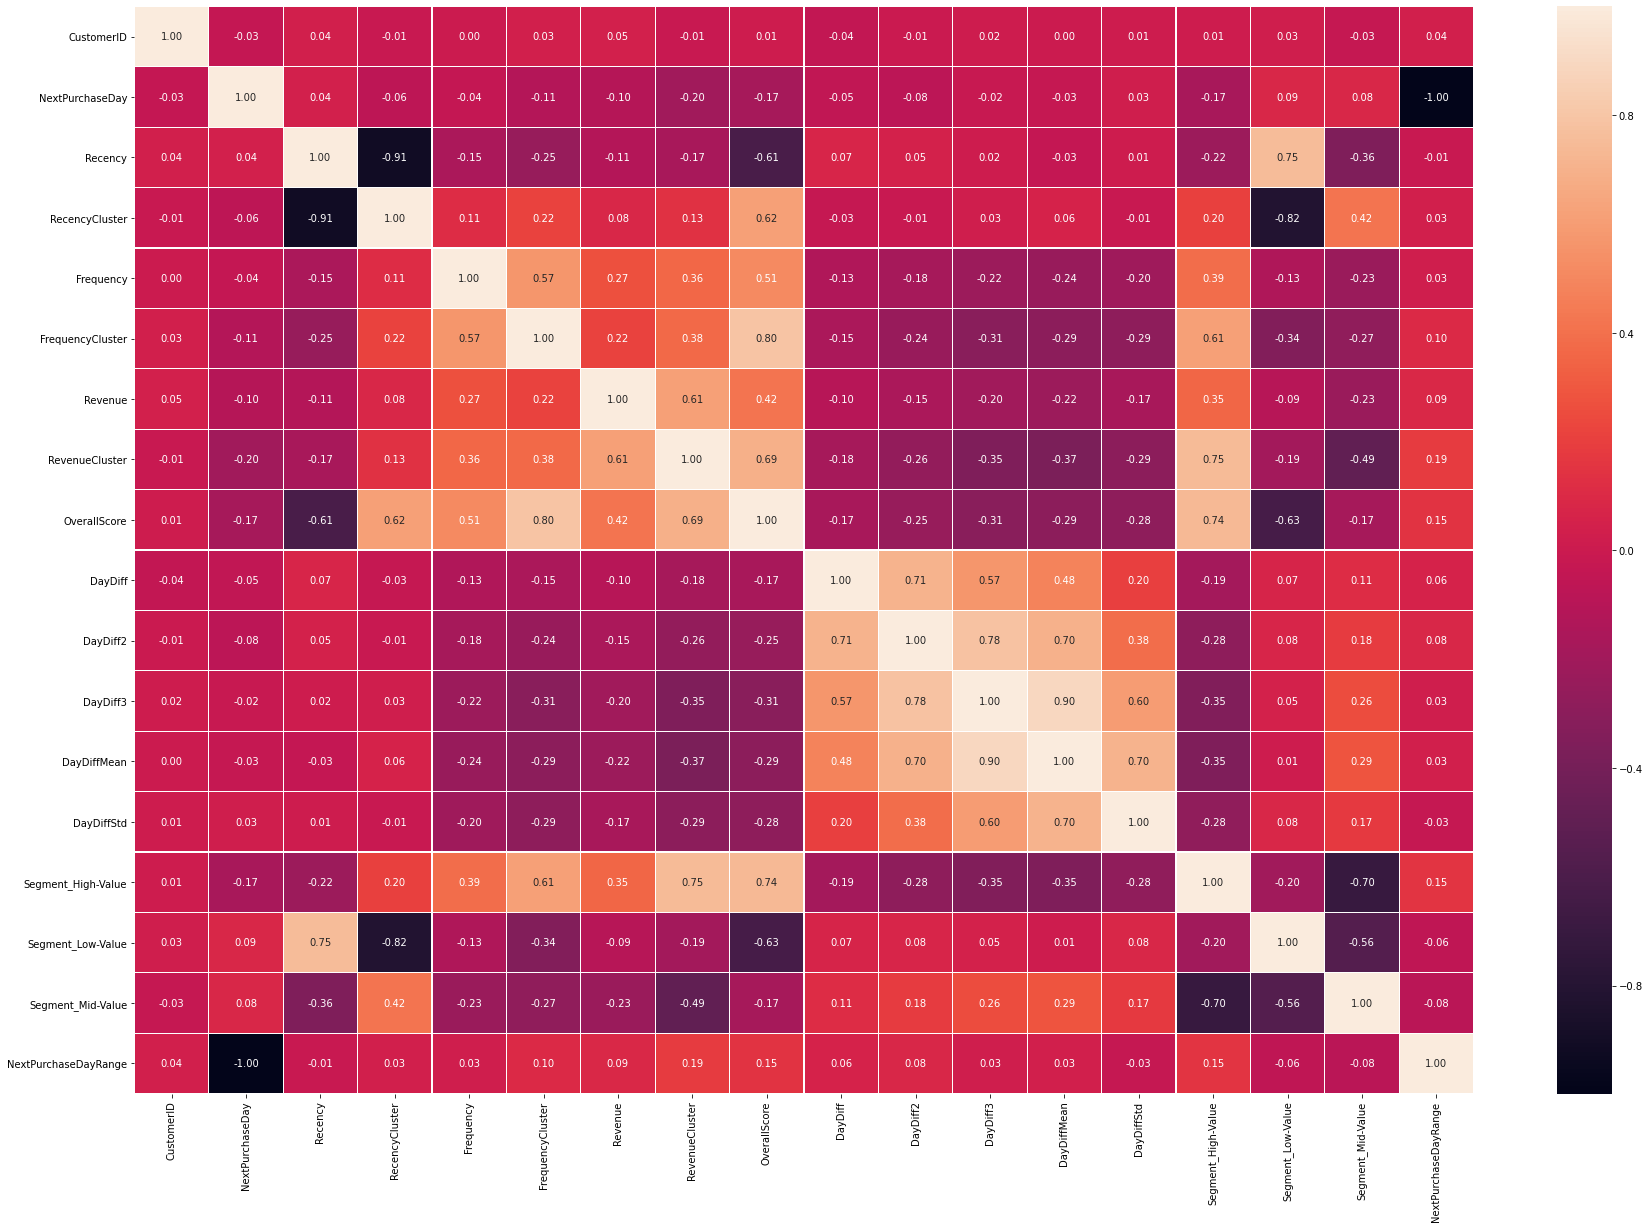

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

#### Overall Score has the highest positive correlation (0.45) and Recency has the highest negative (-0.54)

In [145]:
#train & test split
from sklearn.model_selection import train_test_split

tx_class = tx_class.drop('NextPurchaseDay',axis=1)
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)


In [146]:
#create an array of models
models = []

from sklearn.linear_model import LogisticRegression
models.append(("LR",LogisticRegression()))

from sklearn.naive_bayes import GaussianNB
models.append(("NB",GaussianNB()))

from sklearn.ensemble import RandomForestClassifier
models.append(("RF",RandomForestClassifier()))

from sklearn.svm import SVC
models.append(("SVC",SVC()))

from sklearn.tree import DecisionTreeClassifier
models.append(("Dtree",DecisionTreeClassifier()))

import xgboost as xgb
models.append(("XGB",xgb.XGBClassifier()))

from sklearn.neighbors import KNeighborsClassifier
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
from sklearn.model_selection import KFold, cross_val_score
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.70030581 0.73006135]
NB [0.60856269 0.49079755]
RF [0.66666667 0.71165644]
SVC [0.70948012 0.73006135]
Dtree [0.62079511 0.65644172]
XGB [0.68501529 0.71472393]
KNN [0.64220183 0.67484663]


#### Hyperparameter tuning

In [147]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.64


In [148]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 3}, 0.7059858164011932)

In [149]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.65


Reference: https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027